*Initially created at 16.02.2018 by Petteri Nevavuori (<petteri.nevavuori@mtech.fi>)*

---

# ML I. Drone Datasets

This notebook lays out the process of building the datasets for training and comparing CNN results with Drone datasets. The comparison will be done with two distinct datasets: earlier and later images. Thus we'll go through the generation of two distinct datasets. The goal for the portion is to have all the necessary components for building a DataLoader which the CNN can then ingest.

The datasets are ingested as minibatches of data. The reasoning behind this is thoroughly assessed by Goodfellow et. al in the book Deep Learning (2016). As minibatch uses random sampling with withdrawal, we'll use that too.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Database-Queries" data-toc-modified-id="1.-Database-Queries-1">1. Database Queries</a></span><ul class="toc-item"><li><span><a href="#1.1-RGB-images" data-toc-modified-id="1.1-RGB-images-1.1">1.1 RGB images</a></span></li><li><span><a href="#1.2-NDVI-images" data-toc-modified-id="1.2-NDVI-images-1.2">1.2 NDVI images</a></span></li><li><span><a href="#1.3-Test-queries" data-toc-modified-id="1.3-Test-queries-1.3">1.3 Test queries</a></span></li><li><span><a href="#1.4-NaN-imputations" data-toc-modified-id="1.4-NaN-imputations-1.4">1.4 NaN imputations</a></span></li></ul></li><li><span><a href="#2.-Dataloaders" data-toc-modified-id="2.-Dataloaders-2">2. Dataloaders</a></span><ul class="toc-item"><li><span><a href="#2.1-Dataset-classes-for-single-samples" data-toc-modified-id="2.1-Dataset-classes-for-single-samples-2.1">2.1 Dataset classes for single samples</a></span></li><li><span><a href="#2.2-Single-Dataloader" data-toc-modified-id="2.2-Single-Dataloader-2.2">2.2 Single Dataloader</a></span><ul class="toc-item"><li><span><a href="#2.2.1-Error:-inconsistent-tensor-sizes---Resolved" data-toc-modified-id="2.2.1-Error:-inconsistent-tensor-sizes---Resolved-2.2.1">2.2.1 Error: inconsistent tensor sizes - Resolved</a></span></li></ul></li><li><span><a href="#2.3-Remaining-Dataloaders" data-toc-modified-id="2.3-Remaining-Dataloaders-2.3">2.3 Remaining Dataloaders</a></span></li><li><span><a href="#2.4-Dataset-to-Dataloader-function" data-toc-modified-id="2.4-Dataset-to-Dataloader-function-2.4">2.4 Dataset to Dataloader function</a></span></li><li><span><a href="#2.5-Dataloader-separation" data-toc-modified-id="2.5-Dataloader-separation-2.5">2.5 Dataloader separation</a></span></li><li><span><a href="#2.6-Troubleshooting-notes" data-toc-modified-id="2.6-Troubleshooting-notes-2.6">2.6 Troubleshooting notes</a></span></li></ul></li><li><span><a href="#3.-Sample-Counts" data-toc-modified-id="3.-Sample-Counts-3">3. Sample Counts</a></span></li></ul></div>

## 1. Database Queries

In this portion we'll research the foundations for building a two-period dataset for Drone RGB and NDVI images. As it stands, there isn't always both images present for every date where there exists a dataset for one or the other. That's why we'll check the RGB images first and NDVI images last.

In [9]:
import datetime
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from field_analysis.db.models import Area, DataPeriod, Target, initialize_db
from field_analysis.settings import data as data_settings
from field_analysis.settings import model as model_settings

In [4]:
initialize_db(os.path.join(model_settings.DATABASES_DIR, 'field_analysis_10m_32px.db'))

### 1.1 RGB images

First we'll examine how many DataPeriods there are in total where there exists both an RGB dataset and a target yield dataset. We're also interest in the number of distinct Areas, as the less there are Areas, more diverse the RGB dataset content is Area-wise temporally. We'll also check the distinct dates there exists proper data.

In [5]:
dataperiods_rgb = (DataPeriod 
    .select(DataPeriod.area,DataPeriod.date,DataPeriod.area_drone_rgb,Target.area_yield)
    .where(DataPeriod.area_drone_rgb.is_null(False))
    .join(Target, on=(Target.area == DataPeriod.area))
    .where(Target.area_yield.is_null(False)))

areas_rgb = (dataperiods_rgb
    .select(DataPeriod.area)
    .distinct())

dates_rgb = (dataperiods_rgb
        .select(DataPeriod.date)
        .distinct()
        .order_by(DataPeriod.date))

print("Total DataPeriods: {}".format(dataperiods_rgb.count()))
print("Distinct Areas: {}".format(areas_rgb.count()))
print("Distinct dates: {}".format(dates_rgb.count()))

Total DataPeriods: 11653
Distinct Areas: 7003
Distinct dates: 8


The number of distinct dates is not that large at all. Let's see the DataPeriod counts for each date.

In [3]:
for date_rgb in dates_rgb:
    count = (dataperiods_rgb
        .select(DataPeriod.id)
        .where(DataPeriod.date == date_rgb.date)
        .count())
    print("Date {}: {} DataPeriods".format(str(date_rgb.date.date()),count))

Date 2017-06-01: 1369 DataPeriods
Date 2017-06-08: 788 DataPeriods
Date 2017-06-15: 3084 DataPeriods
Date 2017-06-22: 754 DataPeriods
Date 2017-07-06: 1888 DataPeriods
Date 2017-07-13: 1523 DataPeriods
Date 2017-07-27: 1404 DataPeriods
Date 2017-08-17: 843 DataPeriods


As it stands, there exists ~6000 DataPeriods before July and ~5660 after it.

### 1.2 NDVI images

Then we'll examine NDVI datasets in similar fashion.

In [4]:
dataperiods_nvdi = (DataPeriod 
    .select(DataPeriod.area,DataPeriod.date,DataPeriod.area_drone_ndvi,Target.area_yield)
    .where(DataPeriod.area_drone_ndvi.is_null(False))
    .join(Target, on=(Target.area == DataPeriod.area))
    .where(Target.area_yield.is_null(False)))

areas_nvdi = (dataperiods_nvdi
    .select(DataPeriod.area)
    .distinct())

dates_nvdi = (dataperiods_nvdi
        .select(DataPeriod.date)
        .distinct()
        .order_by(DataPeriod.date))

print("Total DataPeriods: {}".format(dataperiods_nvdi.count()))
print("Distinct Areas: {}".format(areas_nvdi.count()))
print("Distinct dates: {}".format(dates_nvdi.count()))

Total DataPeriods: 12256
Distinct Areas: 9405
Distinct dates: 9


We'll also assess the DataPeriod counts date-wise.

In [5]:
for date_nvdi in dates_nvdi:
    count = (dataperiods_nvdi
        .select(DataPeriod.id)
        .where(DataPeriod.date == date_nvdi.date)
        .count())
    print("Date {}: {} DataPeriods".format(str(date_nvdi.date.date()),count))

Date 2017-06-01: 1407 DataPeriods
Date 2017-06-08: 795 DataPeriods
Date 2017-06-15: 3084 DataPeriods
Date 2017-06-22: 762 DataPeriods
Date 2017-07-06: 2394 DataPeriods
Date 2017-07-13: 1527 DataPeriods
Date 2017-07-27: 1444 DataPeriods
Date 2017-08-10: 249 DataPeriods
Date 2017-08-17: 594 DataPeriods


Before July there's ~6050 DataPeriods and ~6200 after it. 

### 1.3 Test queries

As it stands, we'll use the month of July as the divider between image datasets. Here we'll perform the queries and count the results just to be sure.

In [6]:
DATE_DIVIDER = datetime.date(2017, 7, 1)

rgb_earlier = (DataPeriod
    .select(DataPeriod.date, DataPeriod.area_drone_rgb, Area.id, Target.area_yield)
    .join(Area)
    .join(Target)
    .where(
        (DataPeriod.area_drone_rgb.is_null(False)) & 
        (DataPeriod.date < DATE_DIVIDER) & 
        (Target.area_yield.is_null(False))))

rgb_later = (DataPeriod
    .select(DataPeriod.date, DataPeriod.area_drone_rgb, Area.id, Target.area_yield)
    .join(Area)
    .join(Target)
    .where(
        (DataPeriod.area_drone_rgb.is_null(False)) & 
        (DataPeriod.date >= DATE_DIVIDER) & 
        (Target.area_yield.is_null(False))))

ndvi_earlier = (DataPeriod
    .select(DataPeriod.date, DataPeriod.area_drone_ndvi, Area.id, Target.area_yield)
    .join(Area)
    .join(Target)
    .where(
        (DataPeriod.area_drone_ndvi.is_null(False)) & 
        (DataPeriod.date < DATE_DIVIDER) & 
        (Target.area_yield.is_null(False))))

ndvi_later = (DataPeriod
    .select(DataPeriod.date, DataPeriod.area_drone_ndvi, Area.id, Target.area_yield)
    .join(Area)
    .join(Target)
    .where(
        (DataPeriod.area_drone_ndvi.is_null(False)) & 
        (DataPeriod.date >= DATE_DIVIDER) & 
        (Target.area_yield.is_null(False))))

print("RGB:\tpre-July={}\tpost-July={}".format(rgb_earlier.count(),rgb_later.count()))
print("NDVI:\tpre-July={}\tpost-July={}".format(ndvi_earlier.count(),ndvi_later.count()))

RGB:	pre-July=5995	post-July=5658
NDVI:	pre-July=6048	post-July=6208


The counts align. We'll also attempt selecting an image and a yield from each of the datasets.

C:\Anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Anaconda3\envs\ml\lib\site-packages\matplotlib\cm.py:256: RuntimeWarning: invalid value encountered in less
  if norm and xx.max() > 1 or xx.min() < 0:


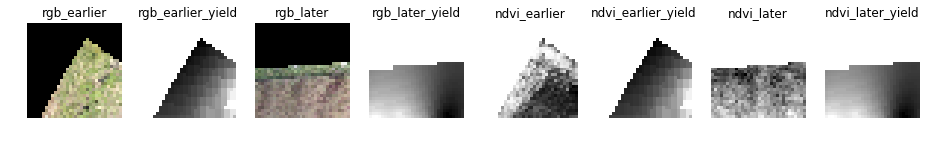

In [9]:
plt.rcParams['figure.figsize'] = 16,4
titles = ['rgb_earlier','rgb_later','ndvi_earlier', 'ndvi_later']

for i, dataset in enumerate((rgb_earlier, rgb_later, ndvi_earlier, ndvi_later)):
        
    title = titles[i]
    dataperiod = dataset[0]
    target = dataperiod.area.target
    
    i_1 = 1 + 2*i
    i_2 = 2 + 2*i
    
    plt.subplot(1,8,i_1)
    if 'rgb' in title:
        
        arr_x = pickle.loads(dataperiod.area_drone_rgb)
        plt.imshow(arr_x)
        
    else:
        
        arr_x = pickle.loads(dataperiod.area_drone_ndvi)
        plt.imshow(arr_x, cmap='gray')
    
    plt.title(title)
    plt.axis('off')
    
    arr_y = pickle.loads(target.area_yield)

    plt.subplot(1,8,i_2)
    plt.imshow(arr_y, cmap='gray')
    plt.title("{}_yield".format(title))
    plt.axis('off')

plt.show()

### 1.4 NaN imputations

As it is evident from the error message, there are some NaNs in the datasets. These will prove to be problematic, which is why we'll perform imputations for those values by changin them to zeros. This is should happen before wrapping the arrays to Tensors.

In [12]:
dataperiod = ndvi_earlier[0]
arr = pickle.loads(dataperiod.area_drone_ndvi)
print("Pre-imputation:",arr[0][:10])
print("Post-imputation:",np.nan_to_num(arr[0])[:10])

Pre-imputation: [nan nan nan nan nan nan nan nan nan nan]
Post-imputation: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 2. Dataloaders

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import traceback
import torch
from torch.utils.data import DataLoader
from field_analysis.model.dataset.dataperiod import DroneRGBEarlier, DroneRGBLater, DroneNDVIEarlier, DroneNDVILater

db_name = 'field_analysis_10m_32px.db'

### 2.1 Dataset classes for single samples

Next up is the building of PyTorch Datasets, which will be accomplished in distinct usable classes. First we'll showcase the item count retrieval. The dataset classes make use of the test queries defined earlier.

In [3]:
print("Training sets:")
print("  DroneRGBEarlier\n\ttrain={}, test={}".format(
    DroneRGBEarlier(db_name).size(),DroneRGBEarlier(db_name,test=True).size()))
print("  DroneRGBLater\n\ttrain={}, test={}".format(
    DroneRGBLater(db_name).size(),DroneRGBLater(db_name,test=True).size()))
print("  DroneNDVIEarlier\n\ttrain={}, test={}".format(
    DroneNDVIEarlier(db_name).size(),DroneNDVIEarlier(db_name,test=True).size()))
print("  DroneNDVILater\n\ttrain={}, test={}".format(
    DroneNDVILater(db_name).size(),DroneNDVILater(db_name,test=True).size()))

Training sets:
  DroneRGBEarlier
	train=5241, test=742
  DroneRGBLater
	train=4647, test=649
  DroneNDVIEarlier
	train=5286, test=740
  DroneNDVILater
	train=5197, test=722


Next we showcase item retrieval from each of the dataset classes. Mind though that the images are converted to Torch Tensors to be properly used by the Torch networks. This is showcased first.

In [2]:
dataset = DroneRGBEarlier(db_name)
dataset[0]

{'x': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8706, 0.7373, 0.8706],
          [0.0000, 0.0000, 0.0000,  ..., 0.7255, 0.7804, 0.8353],
          [0.0000, 0.0000, 0.0000,  ..., 0.7765, 0.8196, 0.8157]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8667, 0.7333, 0.7922],
          [0.0000, 0.0000, 0.0000,  ..., 0.7451, 0.7451, 0.7922],
          [0.0000, 0.0000, 0.0000,  ..., 0.7804, 0.7608, 0.7373]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 

Tensors are easily transformed back to Numpy arrays.

In [4]:
x,y,*metadata = dataset[0].values()
x_arr = x.numpy()
print("x:",type(x_arr),x_arr.shape)

x: <class 'numpy.ndarray'> (3, 32, 32)


We then show also how to retrieve and transform Tensors from each dataset class for visualization. Here we choose a random sample from each dataset.

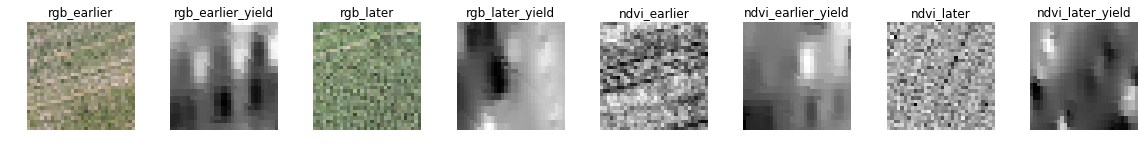

In [7]:
plt.rcParams['figure.figsize'] = 16,4
titles = ['rgb_earlier','rgb_later','ndvi_earlier', 'ndvi_later']

for i, dataset_class in enumerate([DroneRGBEarlier, DroneRGBLater, DroneNDVIEarlier, DroneNDVILater]):
    
    dataset = dataset_class(image_target=True)
    
    title = titles[i]
    
    # This is where the dataset transformation to numpy arrays happens
    x, y = dataset[np.random.randint(0,dataset.size())].values()
    x, y = x.numpy().squeeze(), y.numpy().squeeze()

    i_1 = 1 + 2*i
    i_2 = 2 + 2*i
    
    plt.subplot(1,8,i_1)
    if 'rgb' in title:
        
        plt.imshow(x.transpose(1,2,0))
        
    else:
        
        plt.imshow(x,cmap='gray')
    
    plt.title(title)
    plt.axis('off')
    

    plt.subplot(1,8,i_2)
    plt.imshow(y, cmap='gray')
    plt.title("{}_yield".format(title))
    plt.axis('off')

plt.tight_layout()
plt.show()

### 2.2 Single Dataloader

The bare dataset classes are not however enough for ML training, as we normally want to train with batches. This is why we'll be implementing Dataloaders for each network. Let's show how they are used with these datasets. We'll begin with only a single dataset by retrieving and visualizing a few batches of samples.

In [8]:
from torch.utils.data import DataLoader
from field_analysis.model.dataset.dataperiod import DroneRGBEarlier

dataset = DroneRGBEarlier(db_name=db_name, image_target=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

try:

    for i,batch in enumerate(dataloader):
        
        batch_x = batch['x']
        batch_y = batch['y']
        
        print("Batch",i+1)
        print("\tx:",batch_x.size())
        print("\ty:",batch_y.size())
        
        if i == 3:
            print("Total Batches:",len(dataloader))
            print()
            break
        
except Exception:
    
    traceback.print_exc()

Batch 1
	x: torch.Size([16, 3, 32, 32])
	y: torch.Size([16, 1, 32, 32])
Batch 2
	x: torch.Size([16, 3, 32, 32])
	y: torch.Size([16, 1, 32, 32])
Batch 3
	x: torch.Size([16, 3, 32, 32])
	y: torch.Size([16, 1, 32, 32])
Batch 4
	x: torch.Size([16, 3, 32, 32])
	y: torch.Size([16, 1, 32, 32])
Total Batches: 328



#### 2.2.1 Error: inconsistent tensor sizes - Resolved

> Resolved by implementing a hard-limit on image shapes.

We'll start the troubleshoot by taking few distinct `DataLoader`s and try to locate the problem. Let's try to load a batch with each and see what happens.

In [9]:
dl1 = DataLoader(dataset, batch_size=2)
dl2 = DataLoader(dataset, batch_size=2, shuffle=True)
dl3 = DataLoader(dataset, batch_size=4, shuffle=True)

try:
    for i, loader in enumerate([dl1,dl2,dl3]):
        print("DataLoader",i+1,end="..")
        
        for batch in loader:
            break
            
        print("OK")
        
except Exception:
    traceback.print_exc()

DataLoader 1..OK
DataLoader 2..OK
DataLoader 3..OK


Might the cause be in the sampling method with different `batch_size`? Let's investigate the samplers.

In [10]:
print("DataLoader 1 sampler:",dl1.batch_sampler.sampler)
print("DataLoader 2 sampler:",dl2.batch_sampler.sampler)
print("DataLoader 3 sampler:",dl3.batch_sampler.sampler)

DataLoader 1 sampler: <torch.utils.data.sampler.SequentialSampler object at 0x2abe92aa4400>
DataLoader 2 sampler: <torch.utils.data.sampler.RandomSampler object at 0x2abe92aa4b70>
DataLoader 3 sampler: <torch.utils.data.sampler.RandomSampler object at 0x2abe92aa49b0>


It seems the samplers are different. Let's see the difference between different sampler outputs.

In [11]:
iter_1 = iter(dl1.batch_sampler)
iter_2 = iter(dl2.batch_sampler)
iter_3 = iter(dl3.batch_sampler)
idxs_1 = next(iter_1)
idxs_2 = next(iter_2)
idxs_3 = next(iter_3)

print("Iter 1 sample indices:",idxs_1)
print("Iter 2 sample indices:",idxs_2)
print("Iter 3 sample indices:",idxs_3)

Iter 1 sample indices: [0, 1]
Iter 2 sample indices: [5200, 5227]
Iter 3 sample indices: [2532, 101, 2525, 4394]


So the `RandomSampler` seems to pick random indices to use. As the problem had to do with tensor size mismatch and the `DataLoader` performs the sampling gracefully, let's check the generated tensors and their sizes.

In [12]:
samples_1 = [dataset[i] for i in idxs_1]
samples_2 = [dataset[i] for i in idxs_2]
samples_3 = [dataset[i] for i in idxs_3]

x_shapes = set()
y_shapes = set()
,
[[x_shapes.add(item['x'].size()) for item in samples] for samples in [samples_1,samples_2,samples_3]]
[[y_shapes.add(item['y'].size()) for item in samples] for samples in [samples_1,samples_2,samples_3]]

print("Unique x tensor shapes:", x_shapes)
print("Unique y tensor shapes:", y_shapes)

Unique x tensor shapes: {torch.Size([3, 32, 32])}
Unique y tensor shapes: {torch.Size([1, 32, 32])}


There is mismatch! Some of the `y` tensors have shape `[32, 32]` while others have `[32, 33]`. Uh oh. Time to fix the yield production code.

### 2.3 Remaining Dataloaders

Let's retrieve some batches from all Dataloaders.

In [13]:
from field_analysis.model.dataset.dataperiod import (DroneRGBEarlier, DroneRGBLater, 
                                                     DroneNDVIEarlier, DroneNDVILater)

for dataset in [DroneNDVIEarlier(db_name), DroneNDVILater(db_name), 
                DroneRGBEarlier(db_name), DroneRGBLater(db_name)]:
    
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    print(dataset.__class__.__name__)
    
    for i, batch in enumerate(dataloader):
        
        batch_x = batch['x']
        batch_y = batch['y']
        
        print("\tBatch",i+1)
        print("\t\tx:",batch_x.size())
        print("\t\ty:",batch_y.size())
        
        if i == 3:
            print("\tTotal Batches:",len(dataloader))
            print()
            break

DroneNDVIEarlier
	Batch 1
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Batch 2
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Batch 3
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Batch 4
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Total Batches: 331

DroneNDVILater
	Batch 1
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Batch 2
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Batch 3
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Batch 4
		x: torch.Size([16, 1, 32, 32])
		y: torch.Size([16])
	Total Batches: 325

DroneRGBEarlier
	Batch 1
		x: torch.Size([16, 3, 32, 32])
		y: torch.Size([16])
	Batch 2
		x: torch.Size([16, 3, 32, 32])
		y: torch.Size([16])
	Batch 3
		x: torch.Size([16, 3, 32, 32])
		y: torch.Size([16])
	Batch 4
		x: torch.Size([16, 3, 32, 32])
		y: torch.Size([16])
	Total Batches: 328

DroneRGBLater
	Batch 1
		x: torch.Size([16, 3, 32, 32])
		y: torch.Size([16])
	Batch 2
		x: torch.Size([16, 3, 32, 32])
	

### 2.4 Dataset to Dataloader function

Then we test if the implemented Dataset-to-Dataloader function works as intended.

In [14]:
from field_analysis.model.dataset.dataperiod import (DroneRGBEarlier, DroneRGBLater, 
                                                     DroneNDVIEarlier, DroneNDVILater)

for dataset in [DroneNDVIEarlier(db_name), DroneNDVILater(db_name), DroneRGBEarlier(db_name), DroneRGBLater(db_name)]:
    
    print(dataset.__class__.__name__)
    print("\tTotal Batches:",len(dataset.to_batches(batch_size=16)))
    print()


DroneNDVIEarlier
	Total Batches: 331

DroneNDVILater
	Total Batches: 325

DroneRGBEarlier
	Total Batches: 328

DroneRGBLater
	Total Batches: 291



It does, great! However in the context of deep learning the use of the whole dataset is neither optimal or the industry standard.

### 2.5 Dataloader separation

Separation to distinct training and validation is the standard for the moment. Thus we'll showcase the implementation of this as well.

In [15]:
from field_analysis.model.dataset.dataperiod import (DroneRGBEarlier, DroneRGBLater, 
                                                     DroneNDVIEarlier, DroneNDVILater)

for dataset in [DroneNDVIEarlier(db_name), DroneNDVILater(db_name), DroneRGBEarlier(db_name), DroneRGBLater(db_name)]:
    
    print(dataset.__class__.__name__)
    
    train, val = dataset.separate_train_test(batch_size=16, train_ratio=0.8)
    
    print("\tTrain size={}, Validation size={}".format(len(train),len(val)))
    print()

DroneNDVIEarlier
	Train size=265, Validation size=67

DroneNDVILater
	Train size=260, Validation size=65

DroneRGBEarlier
	Train size=263, Validation size=66

DroneRGBLater
	Train size=233, Validation size=59



Splendid again! Dataloaders are finished!

### 2.6 Troubleshooting notes

When using multiple dataloaders within a training instance, it is important to use the initialized dataset at once. Let's take the 32px and 64px datasets as an example. We'll first initialize two datasets sequentially.

In [16]:
from field_analysis.model.dataset.dataperiod import DroneNDVIEarlier

db_32 = 'field_analysis_10m_32px.db'
db_64 = 'field_analysis_20m_64px.db'
datasets = []

for db in [db_32, db_64]:
    datasets.append(DroneNDVIEarlier(db))
    
for dataset in datasets:
    print(dataset[0]['x'].size())

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


As it is evident, while the first dataset was initialized with the 32px dataset, both retrievals produced similarly shaped results. This is due to dynamic database selection implemented within `field_analysis.db.models` in the function `initialize_db`. The datasets call this initialization function at their initialization time and override the ORM models' database file pointer.

## 3. Sample Counts

We want to find out the total sample counts of complete input-target-pairs. This is to say that we are interested in pairs which contain non-null values for both the target and the input. We do this for each dataset separately.

In [2]:
import os

import torch
from torch.utils.data import DataLoader

from field_analysis.settings import model as model_settings
from field_analysis.db.models import DataPeriod, Target, initialize_db
from field_analysis.model.dataset.dataperiod import (
    DroneRGBEarlier, DroneRGBLater, DroneNDVIEarlier, DroneNDVILater)

dbs = ['field_analysis_10m_32px.db',
       'field_analysis_20m_64px.db',
       'field_analysis_40m_128px.db']

for db in dbs:
    initialize_db(os.path.join(model_settings.DATABASES_DIR, db))
    
    print(db)

    count = 0
    count += DataPeriod.select().where(DataPeriod.area_drone_rgb.is_null(False)).count()
    count += DataPeriod.select().where(DataPeriod.area_drone_ndvi.is_null(False)).count()
    print("\t{} inputs".format(count))
    
    print("\t{} targets".format(Target.select().where(Target.area_yield.is_null(False)).count()))
    
    size = 0
    size += DroneRGBEarlier(db).size()
    size += DroneRGBLater(db).size()
    size += DroneNDVIEarlier(db).size()
    size += DroneNDVILater(db).size()
    print("\t{} input-target-pairs".format(size))
    
    size = 0
    size += DroneRGBEarlier(db).size()
    size += DroneNDVIEarlier(db).size()
    print("\t{} earlier samples".format(size))
    
    size = 0
    size += DroneRGBLater(db).size()
    size += DroneNDVILater(db).size()
    print("\t{} later samples".format(size))
    

field_analysis_10m_32px.db
	29811 inputs
	12116 targets
	20371 input-target-pairs
	10527 earlier samples
	9844 later samples
field_analysis_20m_64px.db
	29850 inputs
	12067 targets
	20404 input-target-pairs
	10563 earlier samples
	9841 later samples
field_analysis_40m_128px.db
	29322 inputs
	11716 targets
	20193 input-target-pairs
	10521 earlier samples
	9672 later samples
